In [23]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam
import matplotlib as mpl
from keras.utils import plot_model
%matplotlib inline


## Data Loading

In [10]:
def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    return train, test

## Data Preprocessing

In [1]:
def preprocess_data(train, test):
    X = train.iloc[:, 1:785]
    y = train.iloc[:, 0]
    X_test = test.iloc[:, 0:784]

    X = X / 255.0
    X_test = X_test / 255.0
    
    # Reshape images
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=1212)
    x_train_re = X_train.to_numpy().reshape(X_train.shape[0], 28, 28, 1)
    x_validation_re = X_validation.to_numpy().reshape(X_validation.shape[0], 28, 28, 1)
    x_test_re = X_test.to_numpy().reshape(X_test.shape[0], 28, 28, 1)
    
    return x_train_re, y_train, x_validation_re, y_validation, x_test_re


In [21]:
def preprocess_data_for_tsne(train):
    X = train.iloc[:, 1:785]  # Feature columns
    y = train.iloc[:, 0]      # Label column
    return X, y


## Visualization Functions

In [2]:
def plot_digits(data, labels, num_digits):
    num_cells = math.ceil(math.sqrt(num_digits))
    plt.figure(figsize=(10, 10))
    for i in range(num_digits):
        plt.subplot(num_cells, num_cells, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[i].reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

In [3]:
def plot_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'go-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'ro-', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'mo-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [18]:
def plot_tsne(X, y):
    X_normalized = X / 255.0
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_res = tsne.fit_transform(X_normalized)
    
    plt.figure(figsize=(14, 12))
    # Access colormap using new recommended method
    cmap = mpl.colormaps['jet']
    scatter = plt.scatter(tsne_res[:, 0], tsne_res[:, 1], c=y, cmap=cmap, marker='o', s=2, edgecolor='k')
    plt.colorbar(scatter, ticks=range(10))
    plt.xticks([])
    plt.yticks([])
    plt.title('t-SNE visualization of the digits')
    plt.show()

## Model Definitions

### Base model

In [15]:
def create_base_model(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

### Refined model

In [5]:
def create_refined_model(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=5, activation='relu', input_shape=input_shape,
                     kernel_initializer='VarianceScaling',
                     kernel_regularizer=l2(0.01)))  # L2 regularization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=5, activation='relu', 
                     kernel_initializer='VarianceScaling',
                     kernel_regularizer=l2(0.01)))  # L2 regularization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## Training the model

In [6]:
def train_model(model, x_train, y_train, x_val, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val),
                        callbacks=[early_stopping, learning_rate_reduction], batch_size=100)
    
    plot_history(history)
    return history


## Evaluation and Prediction Function

In [7]:
def evaluate_model(model, x_train, y_train, x_val, y_val):
    train_loss, train_accuracy = model.evaluate(x_train, y_train)
    val_loss, val_accuracy = model.evaluate(x_val, y_val)
    print('Train loss:', train_loss)
    print('Train accuracy:', train_accuracy)
    print('Validation loss:', val_loss)
    print('Validation accuracy:', val_accuracy)

## Saving and Loading the model Functions

In [8]:
def save_model(model, filename):
    model.save(filename)

def load_model(filename):
    return tf.keras.models.load_model(filename)

Plot t-SNE...


/var/folders/y3/7t134x0x04xglfbbg5tf61nh0000gn/T/ipykernel_30625/3906702507.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(tsne_res[:, 0], tsne_res[:, 1], c=y, cmap=plt.cm.get_cmap("jet", 10), marker='o', s=2, edgecolor='k')


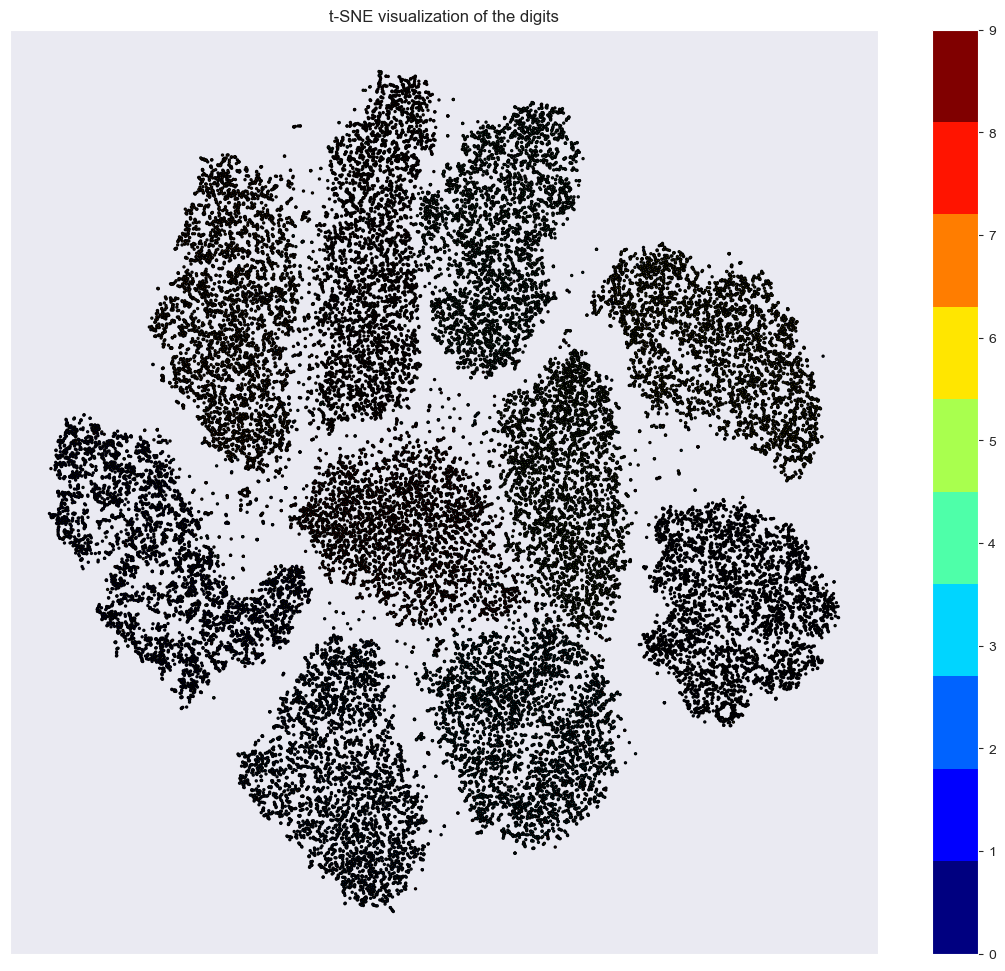

In [24]:
def main():
    train, test = load_data()
    
    X_tsne, y_tsne = preprocess_data_for_tsne(train)  # Preprocess specifically for t-SNE
    print("Plot t-SNE...")
    plot_tsne(X_tsne, y_tsne)  
    
    x_train, y_train, x_val, y_val, x_test = preprocess_data(train, test)
    print("Training Base Model...")
    base_model = create_base_model((28, 28, 1))
    print(base_model.summary())
    plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')
    train_model(base_model, x_train, y_train, x_val, y_val)
    evaluate_model(base_model, x_train, y_train, x_val, y_val)

    print("Training Refined Model...")
    refined_model = create_refined_model((28, 28, 1))
    print(refined_model.summary())
    plot_model(refined_model, show_shapes=True, show_layer_names=True, to_file='refined_model.png')
    train_model(refined_model, x_train, y_train, x_val, y_val)
    evaluate_model(refined_model, x_train, y_train, x_val, y_val)

main()